In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import csv

import sys

sys.path.append("../../")

In [2]:
show_animation = True
WORLD_SIZE = 500
# Vehicle parameters
NX = 5  # x = x,y,v,yaw,omega
NU = 2  # a = [velocity,steer]
DT = 0.5

# Vehicle parameters描画用らしい
LENGTH = 4.5  # [m]
WIDTH = 2  # [m]
BACKTOWHEEL = 1  # [m]
WHEEL_LEN = 0.3  # [m]
WHEEL_WIDTH = 0.2  # [m]
TREAD = 0.7  # [m]
WB = 2.5  # [m]

MAX_STEERING_ANGLE = math.radians(45.0)  # maximum steering angle [rad]
MAX_DSTEER = math.radians(30.0)  # maximum steering speed [rad/s]

In [3]:
class Config():
    # simulation parameters

    def __init__(self):
        # robot parameter
        self.max_speed = 5  # [m/s]
        self.min_speed = 0  # [m/s]
        self.max_yawrate = 40.0 * math.pi / 180.0  # [rad/s]
        self.max_accel = 0.5  # [m/ss]
        self.max_dyawrate = 40.0 * math.pi / 180.0  # [rad/ss]
        self.v_reso = 0.1  # [m/s]
        self.yawrate_reso = 1 * math.pi / 180.0  # [rad/s]
        self.dt = 1.0  # [s]
        self.predict_time = 1.0  # [s]
        self.to_goal_cost_gain = 0.0
        self.speed_cost_gain = 1.0
        self.ob_cost_gain = 0.0
        self.to_goal_dis_cost_gain = 1.0
        self.robot_radius = 3.0  # [m]

In [4]:
def motion(x, u, dt):
    # motion model for two-wheel robot x,y,orient,v,steering

    x[2] += u[1] * dt
    x[0] += u[0] * math.cos(x[2]) * dt
    x[1] += u[0] * math.sin(x[2]) * dt
    x[3] = u[0]
    x[4] = u[1]

    return x

In [5]:
def calc_dynamic_window(x, config):
    # Dynamic window from robot specification
    Vs = [config.min_speed, config.max_speed,
          -config.max_yawrate, config.max_yawrate]

    # Dynamic window from motion model
    Vd = [x[3] - config.max_accel * config.dt,
          x[3] + config.max_accel * config.dt,
          x[4] - config.max_dyawrate * config.dt,
          x[4] + config.max_dyawrate * config.dt]

    #  [vmin,vmax, yawrate min, yawrate max]
    dw = [max(Vs[0], Vd[0]), min(Vs[1], Vd[1]),
          max(Vs[2], Vd[2]), min(Vs[3], Vd[3])]

    return dw

In [6]:
def calc_trajectory(xinit, v, y, config):
    x = np.array(xinit)
    traj = np.array(x)
    time = 0
    while time <= config.predict_time:
        x = motion(x, [v, y], config.dt)
        traj = np.vstack((traj, x))
        time += config.dt

    return traj

In [7]:
def calc_final_input(x, u, dw, config, goal, ob):
    xinit = x[:]
    min_cost = 10000.0
    min_u = u
    min_u[0] = 0.0
    best_traj = np.array([x])

    # evalucate all trajectory with sampled input in dynamic window
    for v in np.arange(dw[0], dw[1], config.v_reso):
        for y in np.arange(dw[2], dw[3], config.yawrate_reso):
            traj = calc_trajectory(xinit, v, y, config)

            # calc cost
            to_goal_cost = config.to_goal_cost_gain * calc_to_goal_cost(traj, goal, config)
            to_goal_dis_cost = config.to_goal_dis_cost_gain * calc_to_goal_dis_cost(traj, goal, config)
            speed_cost = config.speed_cost_gain * \
                         (config.max_speed - traj[-1, 3])  # traj[-1,3] velocity
            # ob_cost = config.ob_cost_gain * calc_obstacle_cost(traj, ob, config)
            # print(ob_cost)

            final_cost = to_goal_cost + speed_cost + to_goal_dis_cost

            # search minimum trajectory
            if min_cost >= final_cost:
                min_cost = final_cost
                min_u = [v, y]
                best_traj = traj

    return min_u, best_traj

In [8]:
def calc_whole_subgoal_final_input(x, u, dw, config, goal_loc, main_index):
    xinit = x[:]
    min_cost = 10000.0
    min_u = u
    min_u[0] = 0.0
    best_traj = np.array([x])

    # evalucate all trajectory with sampled input in dynamic window
    for v in np.arange(dw[0], dw[1], config.v_reso):
        for y in np.arange(dw[2], dw[3], config.yawrate_reso):
            traj = calc_trajectory(xinit, v, y, config)

            # calc cost
            # to_goal_cost = config.to_goal_cost_gain * calc_to_goal_cost(traj, config)
            to_goal_dis_cost = config.to_goal_dis_cost_gain * calc_whole_sub_goal_dis_cost(traj, goal_loc, config,
                                                                                           main_index)

            speed_cost = config.speed_cost_gain * \
                         (config.max_speed - traj[-1, 3])  # traj[-1,3] velocity
            # ob_cost = config.ob_cost_gain * calc_obstacle_cost(traj, ob, config)
            # print(ob_cost)

            final_cost = to_goal_dis_cost + speed_cost

            # search minimum trajectory
            if min_cost >= final_cost:
                min_cost = final_cost
                min_u = [v, y]
                best_traj = traj

    return min_u, best_traj

In [9]:
def calc_obstacle_cost(traj, ob, config):
    # calc obstacle cost inf: collistion, 0:free

    skip_n = 2
    minr = float("inf")

    for ii in range(0, len(traj[:, 1]), skip_n):
        for i in range(len(ob[:, 0])):
            ox = ob[i, 0]
            oy = ob[i, 1]
            dx = traj[ii, 0] - ox
            dy = traj[ii, 1] - oy

            r = math.sqrt(dx ** 2 + dy ** 2)
            if r <= config.robot_radius:
                return float("Inf")  # collision

            if minr >= r:
                minr = r

    return 1.0 / minr  # OK

In [10]:
def calc_to_goal_cost(traj, goal, config):
    # calc to goal cost. It is 2D norm.

    goal_magnitude = math.sqrt(goal[0] ** 2 + goal[1] ** 2)
    traj_magnitude = math.sqrt(traj[-1, 0] ** 2 + traj[-1, 1] ** 2)
    dot_product = (goal[0] * traj[-1, 0]) + (goal[1] * traj[-1, 1])
    error = dot_product / (goal_magnitude * traj_magnitude)
    error_angle = math.acos(error)
    cost = config.to_goal_cost_gain * error_angle

    return cost

In [11]:
def calc_to_goal_dis_cost(traj, goal, config):
    # calculate to goal cost by distance

    distance = np.sqrt((goal[0] - traj[-1, 0]) ** 2 + (goal[1] - traj[-1, 1]) ** 2)
    to_goal_dis_cost = config.to_goal_dis_cost_gain * distance

    return to_goal_dis_cost

In [12]:
def calc_whole_sub_goal_dis_cost(traj, goal_loc, config, main_index):
    # calculate whole sub goal cost by distance

    weight_1 = 0.6
    weight_2 = 0.4
    # the initail index of the sub goal
    sub_goal_distance = weight_1 * np.sqrt(
        (goal_loc[main_index][0] - traj[-1, 0]) ** 2 + (goal_loc[main_index][1] - traj[-1, 1]) ** 2) + \
                        weight_2 * np.sqrt(
        (goal_loc[main_index + 1][0] - traj[-1, 0]) ** 2 + (goal_loc[main_index + 1][1] - traj[-1, 1]) ** 2)

    sub_goal_cost = config.to_goal_cost_gain * sub_goal_distance
    return sub_goal_cost

In [13]:
def dwa_control(x, u, config, goal, ob):
    # Dynamic Window control

    dw = calc_dynamic_window(x, config)

    u, traj = calc_final_input(x, u, dw, config, goal, ob)

    return u, traj


def dwa_control_all(x, u, config, goal_loc, main_index):
    # Dynamic Window control with all sub goal

    dw = calc_dynamic_window(x, config)

    u, traj = calc_whole_subgoal_final_input(x, u, dw, config, goal_loc, main_index)

    return u, traj

In [14]:
def plot_arrow(x, y, yaw, length=0.5, width=0.1):  # pragma: no cover
    plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
              head_length=width, head_width=width)
    plt.plot(x, y)

In [15]:
def goal_arrived(x, u, config, goal):
    arrive = False
    if math.sqrt((x[0] - goal[0]) ** 2 + (x[1] - goal[1]) ** 2) <= config.robot_radius:
        print("Goal!!")
        arrive = True
        return arrive

In [16]:
def plot_car(x, y, yaw, steer=0.0, cabcolor="-r", carcolor="-m"):
    outline = np.matrix([[-BACKTOWHEEL, (LENGTH - BACKTOWHEEL), (LENGTH - BACKTOWHEEL), -BACKTOWHEEL, -BACKTOWHEEL],
                         [WIDTH / 2, WIDTH / 2, - WIDTH / 2, -WIDTH / 2, WIDTH / 2]])

    fr_wheel = np.matrix([[WHEEL_LEN, -WHEEL_LEN, -WHEEL_LEN, WHEEL_LEN, WHEEL_LEN],
                          [-WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD,
                           -WHEEL_WIDTH - TREAD]])

    rr_wheel = np.copy(fr_wheel)

    fl_wheel = np.copy(fr_wheel)
    fl_wheel[1, :] *= -1
    rl_wheel = np.copy(rr_wheel)
    rl_wheel[1, :] *= -1

    Rot1 = np.matrix([[math.cos(yaw), math.sin(yaw)],
                      [-math.sin(yaw), math.cos(yaw)]])
    Rot2 = np.matrix([[math.cos(steer), math.sin(steer)],
                      [-math.sin(steer), math.cos(steer)]])

    fr_wheel = (fr_wheel.T * Rot2).T
    fl_wheel = (fl_wheel.T * Rot2).T
    fr_wheel[0, :] += WB
    fl_wheel[0, :] += WB

    fr_wheel = (fr_wheel.T * Rot1).T
    fl_wheel = (fl_wheel.T * Rot1).T

    outline = (outline.T * Rot1).T
    rr_wheel = (rr_wheel.T * Rot1).T
    rl_wheel = (rl_wheel.T * Rot1).T

    outline[0, :] += x
    outline[1, :] += y
    fr_wheel[0, :] += x
    fr_wheel[1, :] += y
    rr_wheel[0, :] += x
    rr_wheel[1, :] += y
    fl_wheel[0, :] += x
    fl_wheel[1, :] += y
    rl_wheel[0, :] += x
    rl_wheel[1, :] += y

    plt.plot(np.array(outline[0, :]).flatten(), np.array(outline[1, :]).flatten(), carcolor)
    plt.plot(np.array(fr_wheel[0, :]).flatten(), np.array(fr_wheel[1, :]).flatten(), carcolor)
    plt.plot(np.array(rr_wheel[0, :]).flatten(), np.array(rr_wheel[1, :]).flatten(), carcolor)
    plt.plot(np.array(fl_wheel[0, :]).flatten(), np.array(fl_wheel[1, :]).flatten(), carcolor)
    plt.plot(np.array(rl_wheel[0, :]).flatten(), np.array(rl_wheel[1, :]).flatten(), carcolor)
    plt.plot(x, y, "x")

In [17]:
def land_generator(low,high,size):
    sample_x=np.random.uniform(low, high, size)
    sample_y=np.random.uniform(low, high, size)
    axis=np.stack([sample_x,sample_y],1)
    return axis

def get_ot(st,lmap,max_range):
    dis = np.sqrt((st[0]-lmap[0])**2+(st[1]-lmap[1])**2)
    angle = np.arctan2((lmap[1]-st[1]),(lmap[0]-st[0]))-st[2]
    if (dis < max_range[0]) and (np.abs(angle) < max_range[1]):
        return [dis,angle]
    return [0.0,0.0]

def get_all_ot(st,lmap,max_range):
    measure = []
    for l in range(len(lmap)):
        measure.append( get_ot(st,lmap[l],max_range) )
    return measure

In [18]:
def main():
    np.random.seed(4)
    #print(__file__ + " start!!")
    # initial state [x(m), y(m), yaw(rad), v(m/s), omega(rad/s)]
    x = np.array([2.0, 4.0, 0.0, 0.0, 0.0])
    
    # goal position [x(m), y(m)]
    goal_loc = np.array([
        [60, 90],
        [60, 60],
        [100, 100],
        [100, 40],
    ])
    # goal_loc = np.array([[10, 10],
    #                   [2, 8],
    #                    [6, 6],
    #                    [10, 8]])

    # print(len(goal_loc))
    # obstacles [x(m) y(m), ....]
    ob = np.array([[0, 12],
                   [6, 6],
                   [8, 10],
                   [12, 8]
                   ])

    u = np.array([0.0, 0.0])
    config = Config()
    traj = np.array(x)
    index = 0  # the index of the subgoal
    exit_simu = False
    
    timestep = 1 #時刻step保持
    landmark = land_generator(0.0,100,10) #ランドマーク生成
    lf = open('landmark_data.csv','w')
    writer = csv.writer(lf,lineterminator='\n')
    writer.writerows(landmark)
    lf.close()
    
    max_range = [1000,1000] #計測距離
    
    with open('vehicle_motion_data.csv','w') as f:
        while not exit_simu:
            #csv書き込み
            ot = get_all_ot(x,landmark,max_range)
            ot = np.reshape(ot,(1,len(ot)*2)) #一列に
            data=[[ timestep,x[0],x[1],x[2],u[0],u[1]]]
            data=np.concatenate((data,ot),1) #[time,s_x,s_y,s_yaw,uv,ur,ot[0],,,,ot[N]]
            print(np.shape(data))
            writer = csv.writer(f, lineterminator='\n')
            writer.writerows(data)
            
            u, ltraj = dwa_control(x, u, config, goal_loc[index], ob)

            x = motion(x, u, config.dt)
            timestep +=1
            print(u)
            print(x)
            traj = np.vstack((traj, x))  # store state history

            if show_animation:
                plt.cla()
                plt.plot(ltraj[:, 0], ltraj[:, 1], "-g")
                plt.plot(x[0], x[1], "xr")
#                 plt.plot(goal_loc[0][0], goal_loc[0][1], "go")
#                 plt.plot(goal_loc[1][0], goal_loc[1][1], "ko")
                plot_car(x[0], x[1], x[2], u[1] * 0.1)
#                 plt.plot(goal_loc[2][0], goal_loc[2][1], "ro")
#                 plt.plot(goal_loc[3][0], goal_loc[3][1], "yo")
                for l in range(len(landmark)):
                    plt.plot(landmark[l][0],landmark[l][1],"co")

                plot_arrow(x[0], x[1], x[2])
                plt.axis("equal")
                plt.grid(True)
                plt.pause(0.0001)

            if goal_arrived(x, u, config, goal_loc[index]) and index <= len(goal_loc) - 1:
                index = index + 1
                if index == len(goal_loc):
                    #最終書き込み
                    ot = get_all_ot(x,landmark,max_range)
                    ot = np.reshape(ot,(1,len(ot)*2)) #一列に
                    data=[[ timestep,x[0],x[1],x[2],u[0],u[1]]]
                    data=np.concatenate((data,ot),1)
                    writer = csv.writer(f, lineterminator='\n')
                    writer.writerows(data)
                    break
                    exit_simu = True
                print(index)

    print("Done")
    if show_animation:
        plt.plot(traj[:, 0], traj[:, 1], "-m")
        plt.pause(0.0001)

    plt.show()

(1, 26)
[0.4, 0.5934119456780739]
[2.33161503 4.22367716 0.59341195 0.4        0.59341195]


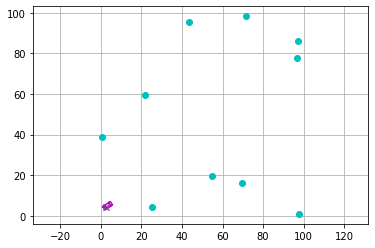

(1, 26)
[0.8, 0.2268928027592646]
[2.87721372 4.80876012 0.82030475 0.8        0.2268928 ]


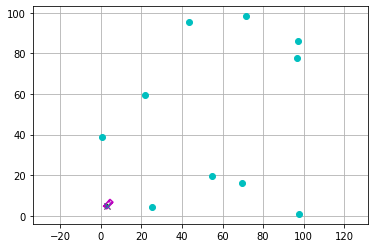

(1, 26)
[1.1999999999999997, 0.10471975511966236]
[3.59939174 5.76712273 0.9250245  1.2        0.10471976]


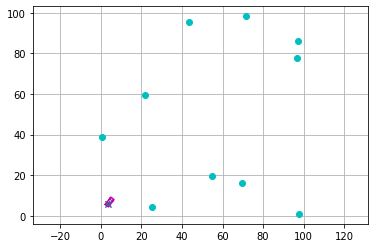

(1, 26)
[1.5999999999999996, 0.03490658503989008]
[4.51711404 7.07776601 0.95993109 1.6        0.03490659]


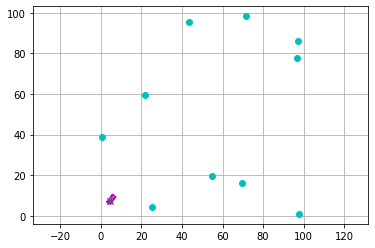

(1, 26)
[2.0000000000000004, 0.01745329251994776]
[5.63549985 8.73584115 0.97738438 2.         0.01745329]


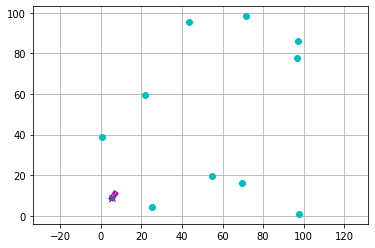

(1, 26)
[2.4000000000000012, 5.440092820663267e-15]
[6.97756282e+00 1.07255313e+01 9.77384381e-01 2.40000000e+00
 5.44009282e-15]


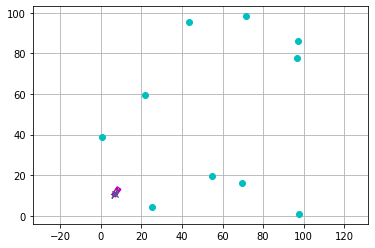

(1, 26)
[2.800000000000002, 6.439293542825908e-15]
[8.54330295e+00 1.30468365e+01 9.77384381e-01 2.80000000e+00
 6.43929354e-15]


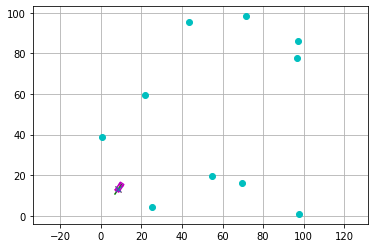

(1, 26)
[3.200000000000003, 7.438494264988549e-15]
[1.03327202e+01 1.56997568e+01 9.77384381e-01 3.20000000e+00
 7.43849426e-15]


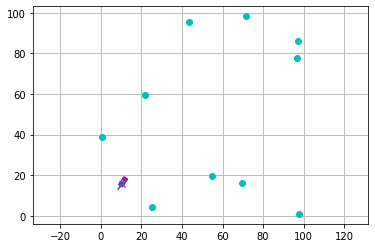

(1, 26)
[3.6000000000000036, 8.43769498715119e-15]
[1.23458147e+01 1.86842920e+01 9.77384381e-01 3.60000000e+00
 8.43769499e-15]


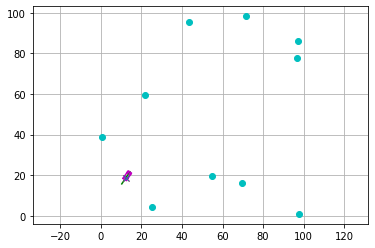

(1, 26)
[4.000000000000004, 9.43689570931383e-15]
[1.45825863e+01 2.20004423e+01 9.77384381e-01 4.00000000e+00
 9.43689571e-15]


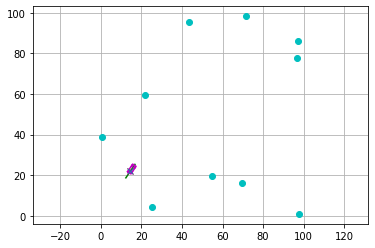

(1, 26)
[4.400000000000006, 1.0436096431476471e-14]
[1.70430351e+01 2.56482076e+01 9.77384381e-01 4.40000000e+00
 1.04360964e-14]


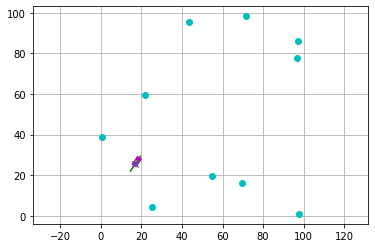

(1, 26)
[4.8000000000000025, 1.1435297153639112e-14]
[1.97271610e+01 2.96275880e+01 9.77384381e-01 4.80000000e+00
 1.14352972e-14]


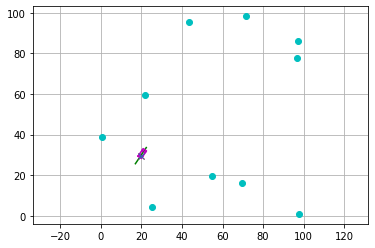

(1, 26)
[4.9, 1.2434497875801753e-14]
[2.24672062e+01 3.36898721e+01 9.77384381e-01 4.90000000e+00
 1.24344979e-14]


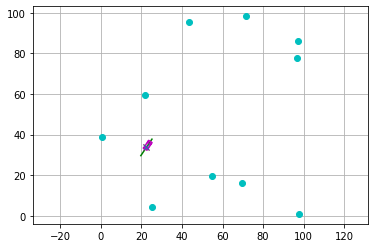

(1, 26)
[4.899999999999999, 1.3433698597964394e-14]
[2.52072515e+01 3.77521562e+01 9.77384381e-01 4.90000000e+00
 1.34336986e-14]


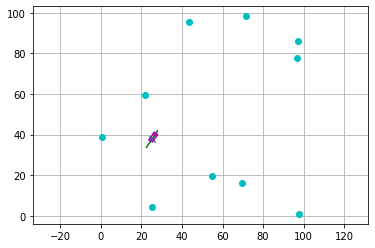

(1, 26)
[4.9999999999999964, 1.4432899320127035e-14]
[2.80032160e+01 4.18973441e+01 9.77384381e-01 5.00000000e+00
 1.44328993e-14]


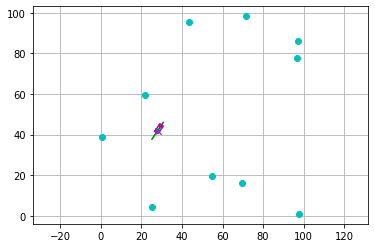

(1, 26)
[4.999999999999995, 1.5432100042289676e-14]
[3.07991805e+01 4.60425319e+01 9.77384381e-01 5.00000000e+00
 1.54321000e-14]


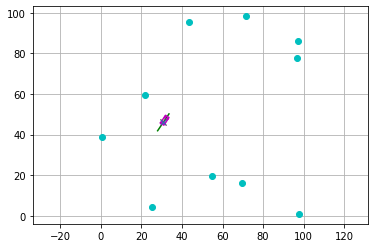

(1, 26)
[4.999999999999993, 1.6431300764452317e-14]
[3.35951450e+01 5.01877198e+01 9.77384381e-01 5.00000000e+00
 1.64313008e-14]


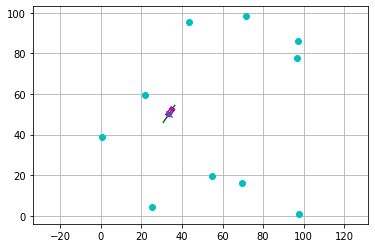

(1, 26)
[4.999999999999991, 1.7430501486614958e-14]
[3.63911095e+01 5.43329076e+01 9.77384381e-01 5.00000000e+00
 1.74305015e-14]


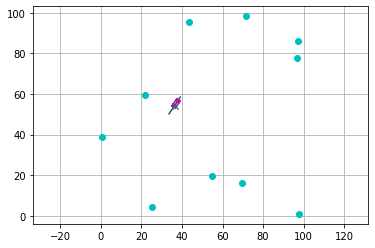

(1, 26)
[4.999999999999989, 1.84297022087776e-14]
[3.91870741e+01 5.84780955e+01 9.77384381e-01 5.00000000e+00
 1.84297022e-14]


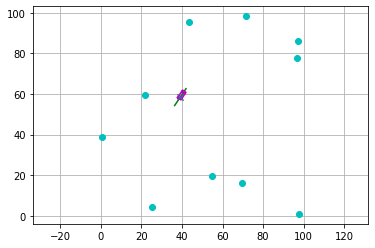

(1, 26)
[4.999999999999988, 1.942890293094024e-14]
[4.19830386e+01 6.26232834e+01 9.77384381e-01 5.00000000e+00
 1.94289029e-14]


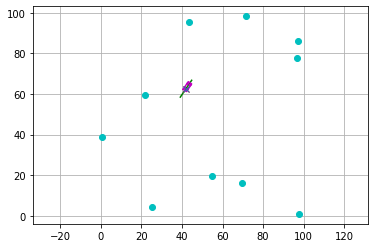

(1, 26)
[4.999999999999986, 2.042810365310288e-14]
[4.47790031e+01 6.67684712e+01 9.77384381e-01 5.00000000e+00
 2.04281037e-14]


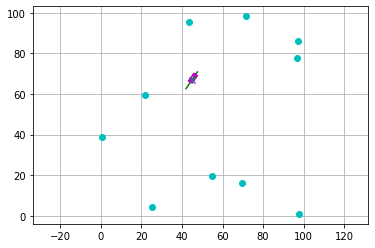

(1, 26)
[4.999999999999984, 2.142730437526552e-14]
[4.75749676e+01 7.09136591e+01 9.77384381e-01 5.00000000e+00
 2.14273044e-14]


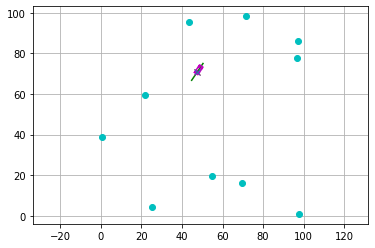

(1, 26)
[4.999999999999982, 0.017453292519965746]
[5.02981628e+01 7.51070119e+01 9.94837674e-01 5.00000000e+00
 1.74532925e-02]


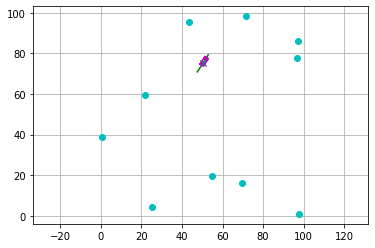

(1, 26)
[4.9999999999999805, 2.3425705819590803e-14]
[5.30213580e+01 7.93003648e+01 9.94837674e-01 5.00000000e+00
 2.34257058e-14]


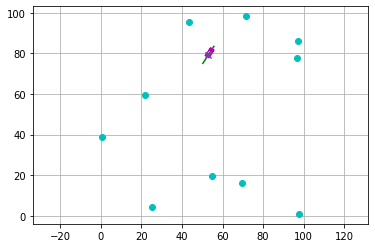

(1, 26)
[4.999999999999979, 2.4424906541753444e-14]
[5.57445531e+01 8.34937176e+01 9.94837674e-01 5.00000000e+00
 2.44249065e-14]


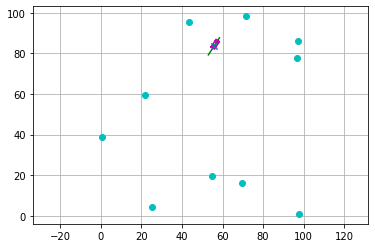

(1, 26)
[4.499999999999979, 2.5424107263916085e-14]
[5.81954288e+01 8.72677352e+01 9.94837674e-01 4.50000000e+00
 2.54241073e-14]


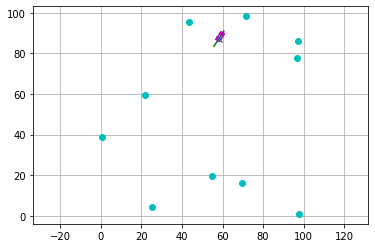

(1, 26)
[3.9999999999999787, 2.6423307986078726e-14]
[6.03739849e+01 9.06224174e+01 9.94837674e-01 4.00000000e+00
 2.64233080e-14]


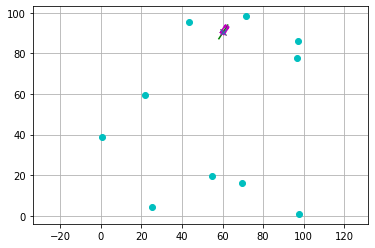

Goal!!
1
(1, 26)
[4.399999999999979, -0.6981317007977054]
[64.58172586 91.90885294  0.29670597  4.4        -0.6981317 ]


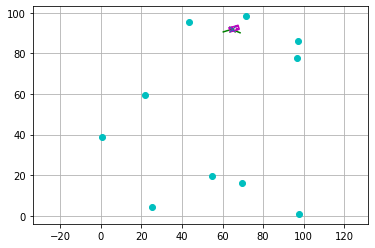

(1, 26)
[4.799999999999979, -0.6981317007977318]
[69.00014916 90.03334352 -0.40142573  4.8        -0.6981317 ]


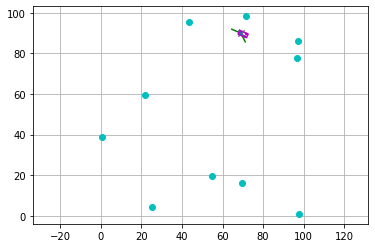

(1, 26)
[4.999999999999977, -0.6981317007977318]
[71.27010165 85.5783109  -1.09955743  5.         -0.6981317 ]


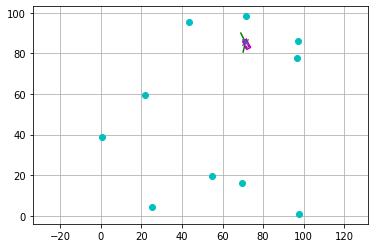

(1, 26)
[4.999999999999975, -0.5585053606381852]
[70.83432294 80.59733741 -1.65806279  5.         -0.55850536]


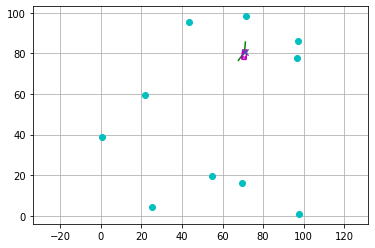

(1, 26)
[4.999999999999973, -0.24434609527920548]
[69.20648217 75.86974453 -1.90240888  5.         -0.2443461 ]


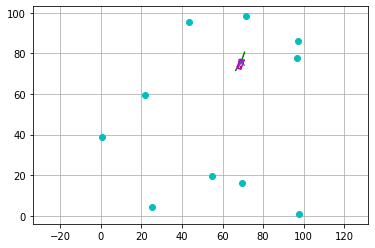

(1, 26)
[4.999999999999972, -0.12217304763960224]
[67.01462643 71.3757743  -2.02458193  5.         -0.12217305]


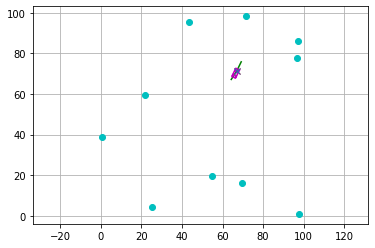

(1, 26)
[4.99999999999997, -0.06981317007977228]
[64.51462643 67.04564728 -2.0943951   5.         -0.06981317]


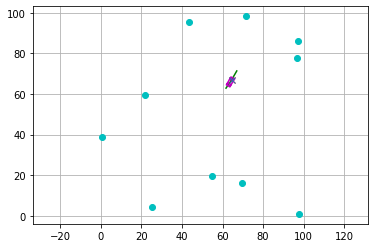

(1, 26)
[4.49999999999997, -0.03490658503988564]
[ 6.21299897e+01  6.32294309e+01 -2.12930169e+00  4.50000000e+00
 -3.49065850e-02]


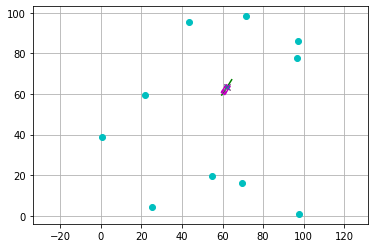

(1, 26)
[3.99999999999997, -0.01745329251994232]
[ 5.99514336e+01  5.98747486e+01 -2.14675498e+00  4.00000000e+00
 -1.74532925e-02]


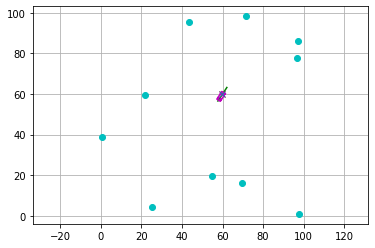

Goal!!
2
(1, 26)
[4.39999999999997, 0.6806784082777905]
[60.41135884 55.49885224 -1.46607657  4.4         0.68067841]


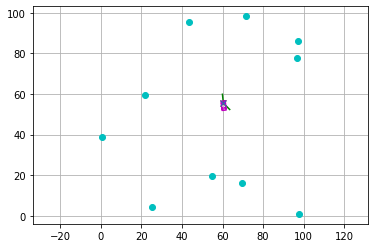

(1, 26)
[4.7999999999999705, 0.6806784082777905]
[63.80547139 52.10473969 -0.78539816  4.8         0.68067841]


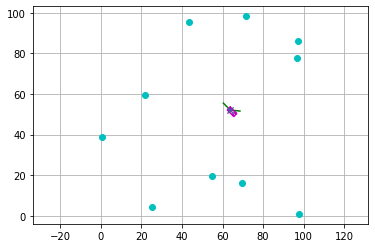

(1, 26)
[4.999999999999968, 0.6806784082777905]
[68.77808087 51.58209737 -0.10471976  5.          0.68067841]


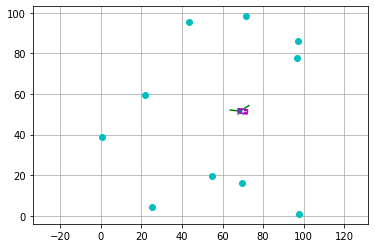

(1, 26)
[4.999999999999966, 0.6632251157578472]
[73.01832135 54.23169369  0.55850536  5.          0.66322512]


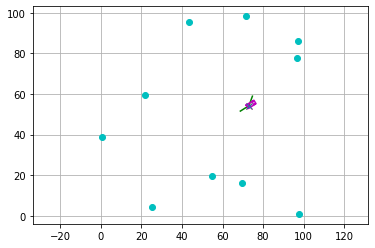

(1, 26)
[4.9999999999999645, 0.296705972839038]
[76.2986165  58.0052416   0.85521133  5.          0.29670597]


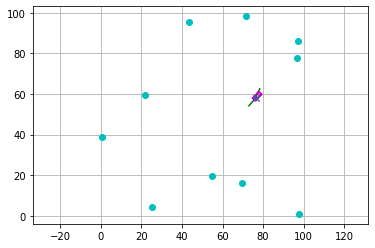

(1, 26)
[4.999999999999963, 0.12217304763960579]
[79.09458101 62.15042946  0.97738438  5.          0.12217305]


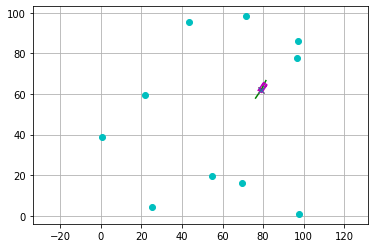

(1, 26)
[4.999999999999961, 0.05235987755983351]
[8.16697714e+01 6.64362660e+01 1.02974426e+00 5.00000000e+00
 5.23598776e-02]


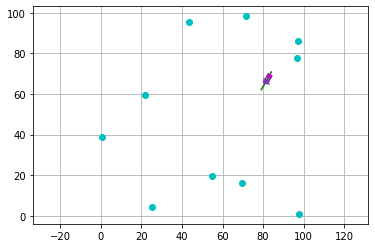

(1, 26)
[4.999999999999959, 0.01745329251994787]
[8.41697714e+01 7.07663930e+01 1.04719755e+00 5.00000000e+00
 1.74532925e-02]


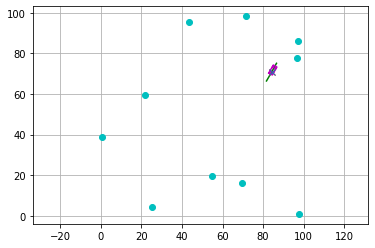

(1, 26)
[4.999999999999957, 0.01745329251994887]
[8.65938195e+01 7.51394915e+01 1.06465084e+00 5.00000000e+00
 1.74532925e-02]


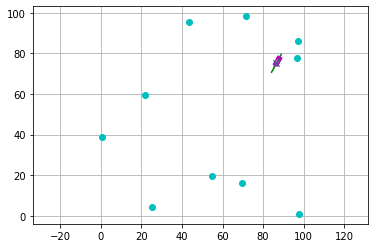

(1, 26)
[4.999999999999956, 6.5503158452884236e-15]
[8.90178676e+01 7.95125901e+01 1.06465084e+00 5.00000000e+00
 6.55031585e-15]


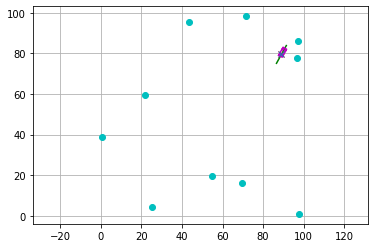

(1, 26)
[4.999999999999954, 0.01745329251995087]
[9.13652254e+01 8.39273280e+01 1.08210414e+00 5.00000000e+00
 1.74532925e-02]


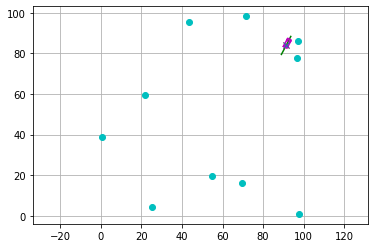

(1, 26)
[4.999999999999952, 8.548717289613705e-15]
[9.37125832e+01 8.83420660e+01 1.08210414e+00 5.00000000e+00
 8.54871729e-15]


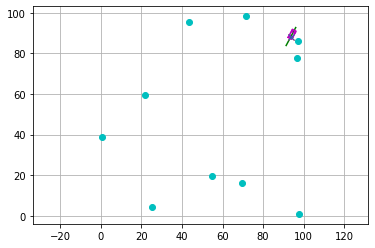

(1, 26)
[4.99999999999995, 9.547918011776346e-15]
[9.60599410e+01 9.27568039e+01 1.08210414e+00 5.00000000e+00
 9.54791801e-15]


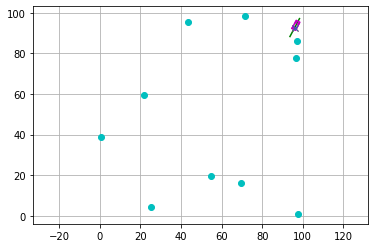

(1, 26)
[4.49999999999995, 1.0547118733938987e-14]
[9.81725631e+01 9.67300681e+01 1.08210414e+00 4.50000000e+00
 1.05471187e-14]


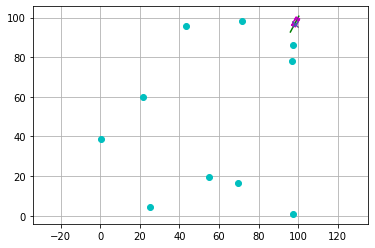

(1, 26)
[3.9999999999999503, -0.017453292519931773]
[ 1.00111802e+02  1.00228547e+02  1.06465084e+00  4.00000000e+00
 -1.74532925e-02]


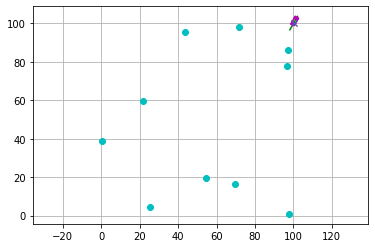

Goal!!
3
(1, 26)
[4.399999999999951, -0.6981317007977318]
[104.21955542 101.80536592   0.36651914   4.4         -0.6981317 ]


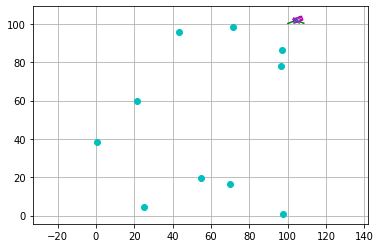

(1, 26)
[4.799999999999951, -0.6981317007977318]
[108.75804459 100.24263878  -0.33161256   4.8         -0.6981317 ]


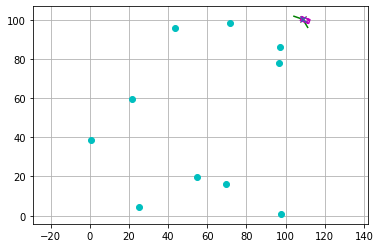

(1, 26)
[4.9999999999999485, -0.6981317007977318]
[111.33323496  95.95680227  -1.02974426   5.          -0.6981317 ]


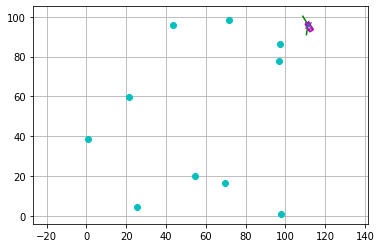

(1, 26)
[4.999999999999947, -0.4537856055185253]
[111.76901367  90.97582878  -1.48352986   5.          -0.45378561]


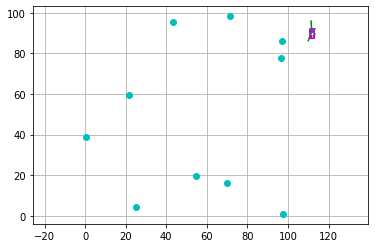

(1, 26)
[4.999999999999945, -0.19198621771937552]
[111.24637136  86.00321931  -1.67551608   5.          -0.19198622]


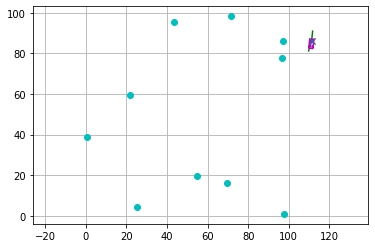

(1, 26)
[4.999999999999943, -0.0872664625997156]
[ 1.10292326e+02  8.10950834e+01 -1.76278254e+00  5.00000000e+00
 -8.72664626e-02]


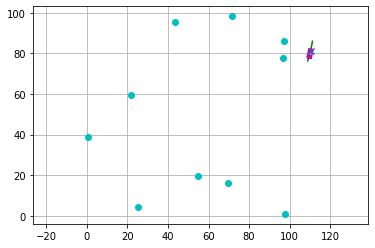

(1, 26)
[4.999999999999941, -0.03490658503988564]
[ 1.09167571e+02  7.62232331e+01 -1.79768913e+00  5.00000000e+00
 -3.49065850e-02]


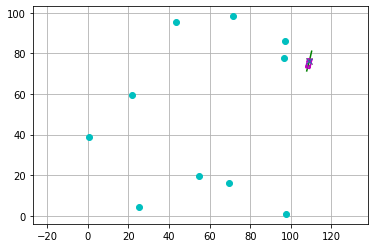

(1, 26)
[4.99999999999994, -0.01745329251994232]
[ 1.07957962e+02  7.13717544e+01 -1.81514242e+00  5.00000000e+00
 -1.74532925e-02]


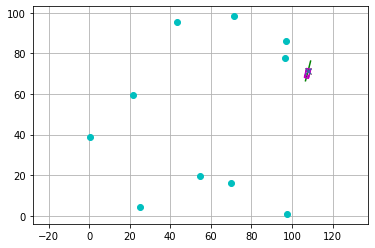

(1, 26)
[4.999999999999938, 9.992007221626409e-16]
[ 1.06748352e+02  6.65202758e+01 -1.81514242e+00  5.00000000e+00
  9.99200722e-16]


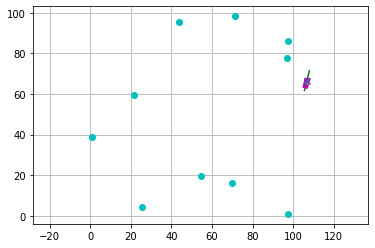

(1, 26)
[4.999999999999936, 1.9984014443252818e-15]
[ 1.05538743e+02  6.16687972e+01 -1.81514242e+00  5.00000000e+00
  1.99840144e-15]


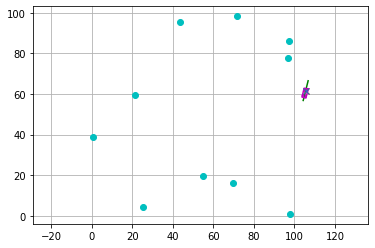

(1, 26)
[4.999999999999934, 2.9976021664879227e-15]
[ 1.04329133e+02  5.68173185e+01 -1.81514242e+00  5.00000000e+00
  2.99760217e-15]


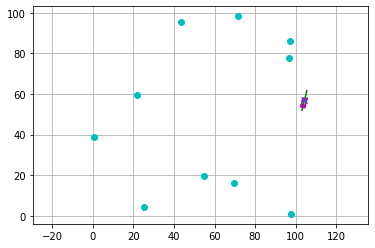

(1, 26)
[4.9999999999999325, 3.9968028886505635e-15]
[ 1.03119524e+02  5.19658399e+01 -1.81514242e+00  5.00000000e+00
  3.99680289e-15]


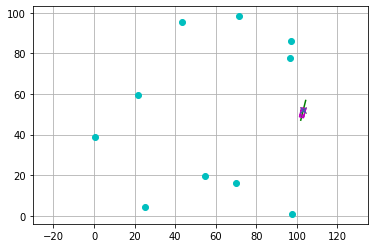

(1, 26)
[4.999999999999931, 4.9960036108132044e-15]
[ 1.01909914e+02  4.71143613e+01 -1.81514242e+00  5.00000000e+00
  4.99600361e-15]


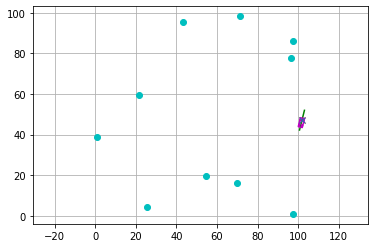

(1, 26)
[4.499999999999931, -0.017453292519937325]
[ 1.00745229e+02  4.27676951e+01 -1.83259571e+00  4.50000000e+00
 -1.74532925e-02]


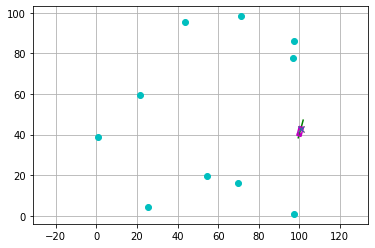

Goal!!
Done


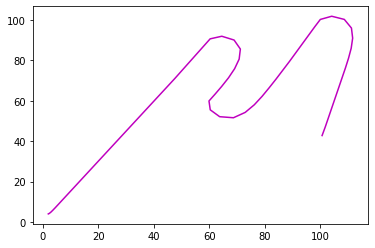

In [19]:

if __name__ == '__main__':
    main()
